<p style="padding: 10px; border: 1px solid black;">
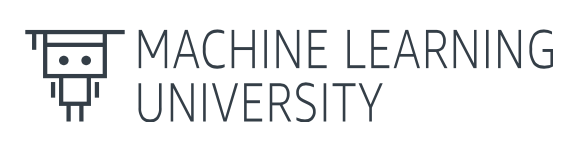 <br/>

# <a name="0">MLU Workshop: Image Generation with Diffusion Models </a>
## <a name="0">Lab 2: Fine-tuning Diffusion Models </a>

This notebook demonstrates how to fine-tune a diffusion model to create a specific entity. During fine-tuning, we can leverage the representation the model learned during pre-training and quickly adapt it to a specific task. This approach can help you obtain a specialized model without comsuming significant compute resources and incuring high costs while benefiting from the generalization capabilities of the pre-trained diffusion model.

In this notebook, we will fine-tune a diffusion model to be able to generate images of the 5th generation echo devices. We will test the fine-tuned model's capabilities in creating 5th generation echo devices in various scenes.
    
1. <a href="#1">Import libraries</a>
2. <a href="#2">Set up AWS Credentials</a>
3. <a href="#3">Set up AWS Credentials</a>
4. <a href="#4">Retrieve Training Artifacts for Fine-tuning</a>
5. <a href="#5">Launch a Training Job to Fine-tune the Diffusion Model </a>
6. <a href="#6">Deploy Fine-tuned Model</a>   
7. <a href="#7">Use the Fine-tuned Model for Inference</a>    
8. <a href="#8">Clean up the endpoint</a>   
9. <a href="#9">Quizzes</a>
    
    
Please work top to bottom of this notebook and don't skip sections as this could lead to error messages due to missing code.

---

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| 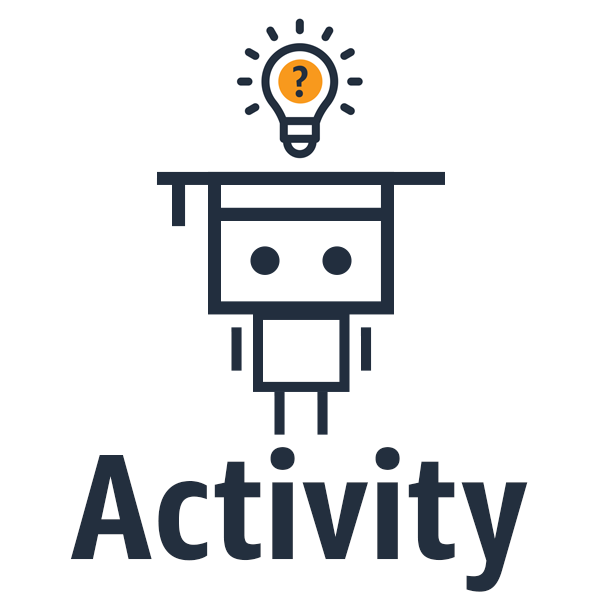| 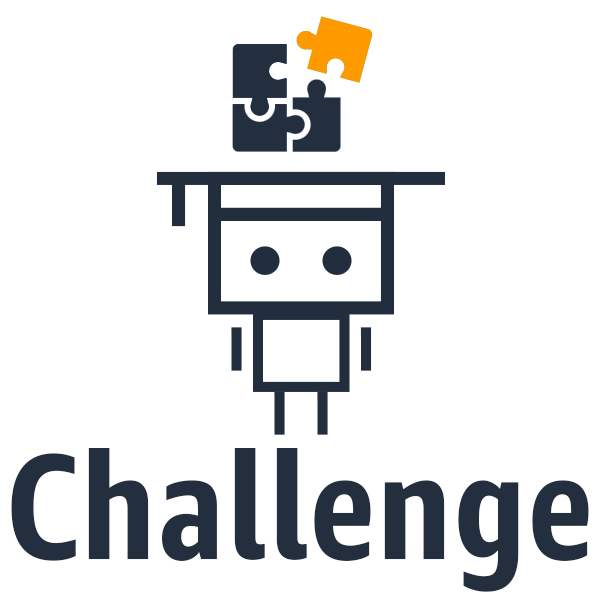|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you test your understanding by taking a short quiz.</p> |

----    

Let's start by loading some libraries and packages!

---

### <a name="1">Import libraries</a>
(<a href="#0">Go to top</a>)

First, let's install and import the necessary libraries.

In [1]:
!pip3 install --upgrade -q sagemaker --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.3 requires botocore==1.34.3, but you have botocore 1.34.150 which is incompatible.
awscli 1.32.3 requires s3transfer<0.10.0,>=0.9.0, but you have s3transfer 0.10.2 which is incompatible.


In [2]:
from ipywidgets import interact, widgets, fixed
from IPython.display import display

import sagemaker, boto3, json
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.utils import name_from_base


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.widgets import RangeSlider
import numpy as np
import pandas as pd
import os
import json


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


### <a name="2">Dataset</a>
(<a href="#0">Go to top</a>)

In order to fine-tune the diffusion model we need some sample images of the custom object the model should learn to generate. In our demonstration, we will be fine-tuning the diffusion model to generate images of the 5th generation echo devices. Fine-tuning the model only requires a few images to associate the custom image with existing tokens and an unique identifier. Let's observe our dataset that we will use for fine-tuning.

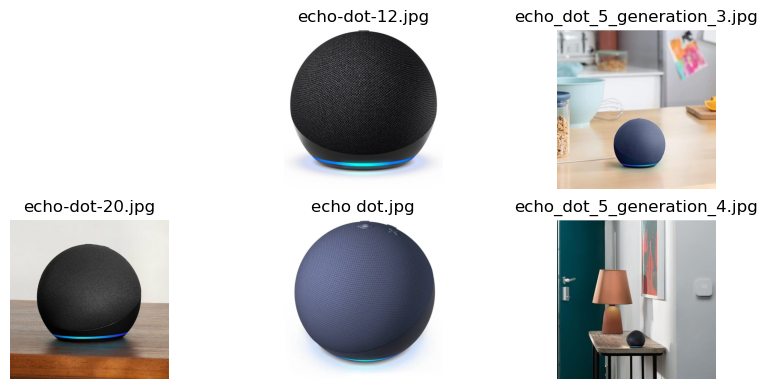

In [3]:
fig = plt.figure(figsize=(10, 7))

files = os.listdir("data")
for i in range(len(files)): 
    #check if file is an image
    if files[i].endswith("jpg"):
        img = mpimg.imread(os.path.join("data",files[i]))
        fig.add_subplot(3, 3, i+1)
        plt.axis("off")
        plt.title(files[i])
        plt.imshow(img)

### <a name="3">Set up AWS Credentials</a>
(<a href="#0">Go to top</a>)

Let's set up the neccessary credentials, define the model configurations.

In [4]:
# Define the role
aws_role = get_execution_role()

# Define the region
aws_region = boto3.Session().region_name

# Instantiate the sagemaker session
sess = sagemaker.Session()

# Instantiate S3 client
s3 = boto3.resource("s3")

# Training dataset path
training_dataset = "./data"

# Select the default S3 bucket
s3_bucket = sess.default_bucket()

#### Set instance prompt

Instance prompt refers to the textual description of images in the training dataset. Try to be as detailed and as accurate as possible. In addition to the textual description, we also need a tag for the specific object we are intending to teach the model. In our case, let's teach the diffusion model to draw the 5th generation echo devices. We will use the tag `[mluecho]` to help the model associate the object with the specific keyword.

In [5]:
# Set the instance prompt for fine-tuning
instance_prompt = "A photo of a [mluecho] smart speaker device"

# Create a JSON file with the instance prompt for fine-tuning
with open(os.path.join(training_dataset, "dataset_info.json"), "w") as f:
    f.write(json.dumps({"instance_prompt": instance_prompt}))

#### Upload the dataset to S3

Let's upload the training data to the default s3 bucket for the training job.

In [6]:
# Set location to upload training data
s3_training_path = f"s3://{s3_bucket}/mlu-diffusion-models/training-dataset/"

# Set location to store output
s3_output = f"s3://{s3_bucket}/mlu-diffusion-models/output/"

# s3.meta.client.upload_file(file_name, 'YOUR_S3_BUCKET_NAME', 'DESIRED_S3_OBJECT_NAME')
!aws s3 cp --recursive $training_dataset $s3_training_path

upload: data/dataset_info.json to s3://sagemaker-us-west-2-859418897854/mlu-diffusion-models/training-dataset/dataset_info.json
upload: data/echo-dot-12.jpg to s3://sagemaker-us-west-2-859418897854/mlu-diffusion-models/training-dataset/echo-dot-12.jpg
upload: data/echo dot.jpg to s3://sagemaker-us-west-2-859418897854/mlu-diffusion-models/training-dataset/echo dot.jpg
upload: data/echo-dot-20.jpg to s3://sagemaker-us-west-2-859418897854/mlu-diffusion-models/training-dataset/echo-dot-20.jpg
upload: data/echo_dot_5_generation_4.jpg to s3://sagemaker-us-west-2-859418897854/mlu-diffusion-models/training-dataset/echo_dot_5_generation_4.jpg
upload: data/echo_dot_5_generation_3.jpg to s3://sagemaker-us-west-2-859418897854/mlu-diffusion-models/training-dataset/echo_dot_5_generation_3.jpg


### <a name="4">Retrieve Training Artifacts for Fine-tuning</a>
(<a href="#0">Go to top</a>)

Here, we retrieve the training docker container, the training algorithm source uri, and the pre-trained base model. Note that model_version="*" fetches the latest model.

We will use a `ml.p3.2xlarge` instance for training. You may choose to select a bigger instance to speed up training.

In [7]:
from sagemaker import image_uris, model_uris, script_uris

# Manually select the model that supports fine-tuning
model_id = "model-txt2img-stabilityai-stable-diffusion-v2-1-base"

# Fetch the latest model version
model_version = "1.*"

# Set the scope for the model
scope = "training"

# Set the instance type
training_instance_type = "ml.p3.2xlarge"

# Retrieve the docker image suitable for this job
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=model_id,
    model_version=model_version,
    image_scope=scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope=scope
)

# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope=scope
)

Using model 'model-txt2img-stabilityai-stable-diffusion-v2-1-base' with wildcard version identifier '1.*'. You can pin to version '1.1.3' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


### <a name="5">Launch a Training Job to Fine-tune the Diffusion Model</a>
(<a href="#0">Go to top</a>)

In this section, we will launch a training job to fine-tune the diffusion model to create 5th generation echo devices.


#### Set hyperparametrs for the training job

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path: This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. We defined the training instance type above to fetch the correct `train_image_uri`.

The second set of parameters are algorithm specific training hyper-parameters.

---

In [8]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=model_id, model_version=model_version
)

# [Optional] Override default hyperparameters with custom values. This controls the duration of the training and the quality of the output.
# If max_steps is too small, training will be fast but the the model will not be able to generate custom images for your usecase.
# If max_steps is too large, training will be very slow.
hyperparameters["max_steps"] = "600"
pd.DataFrame.from_dict(hyperparameters, orient="index", columns=["Hyperparameters"])

,Hyperparameters
epochs,20
max_steps,600
batch_size,1
with_prior_preservation,False
num_class_images,100
learning_rate,2e-06
prior_loss_weight,1.0
center_crop,False
lr_scheduler,constant
adam_weight_decay,0.01


#### Create the training job

We start by creating the estimator object with all the required assets and then launch the training job.  It should take less than 15 minutes for the given dataset.

---

In [9]:
%%time
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"mlu-wksp-diffusion-{model_id}-fine-tuning")

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output,
    base_job_name=training_job_name,
)

# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit({"training": s3_training_path}, logs=True)

INFO:sagemaker:Creating training-job with name: mlu-wksp-diffusion-model-txt2img-stabil-2024-07-30-17-53-22-222


2024-07-30 17:53:22 Starting - Starting the training job...
2024-07-30 17:53:40 Pending - Training job waiting for capacity...
2024-07-30 17:54:05 Pending - Preparing the instances for training...
2024-07-30 17:54:43 Downloading - Downloading input data..................
2024-07-30 17:57:49 Downloading - Downloading the training image...............
2024-07-30 18:00:21 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-30 18:00:43,807 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-30 18:00:43,834 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-07-30 18:00:43,836 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-07-30 18:00:45,807 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda

---

### <a name="6">Deploy Fine-tuned Model</a>
(<a href="#0">Go to top</a>)

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We start by retrieving the JumpStart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `sd_estimator` that we have fine-tuned.


In [ ]:
%%time

inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"mlu-diffusion-models-FT-{model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = sd_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-west-2-859418897854/mlu-diffusion-models/output/mlu-wksp-diffusion-model-txt2img-stabil-2024-07-30-17-53-22-222/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-west-2/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-859418897854/sagemaker-jumpstart-2024-07-30-18-09-16-006/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2024-07-30-18-09-16-006
INFO:sagemaker:Creating endpoint-config with name mlu-diffusion-models-FT-model-txt2img-s-2024-07-30-18-09-16-005
INFO:sagemaker:Creating endpoint with name mlu-diffusion-models-FT-model-txt2img-s-2024-07-30-18-09-16-005


--------------!CPU times: user 6min 18s, sys: 1min 10s, total: 7min 28s
Wall time: 17min 9s


---

### <a name="7">Use the Fine-tuned Model for Inference</a>
(<a href="#0">Go to top</a>)

In [14]:
from mlu_utils.helper import query_response

# Inference parameters
payload = {
    "prompt": "PROMPT FOR THE DIFFUSION MODEL",
    "num_images_per_prompt": 1,
    "num_inference_steps": 75,
    "guidance_scale": 7.5,
    "seed": 1,
}

Let's test our fine-tuned model by prompting it to generate images of the 5th generation echo device by using our custom phrase `[mluecho]`.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;">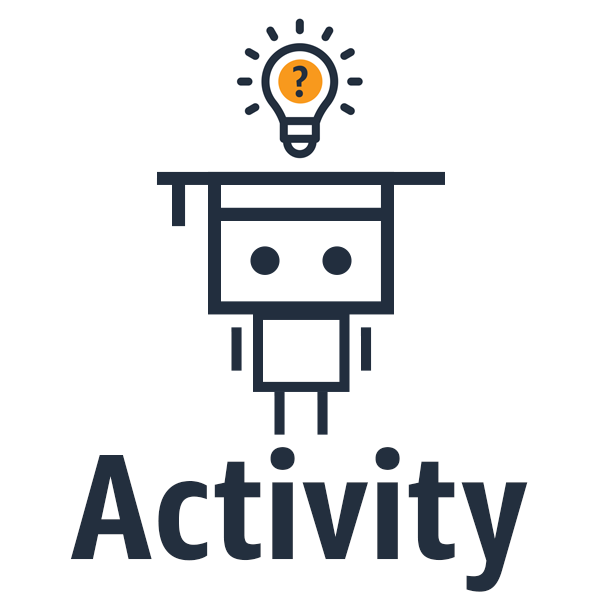 </p>
    <p style=" text-align: center; margin: auto;">Test the fine-tuned model by trying different prompts and examining the images generated.</p>
    <br>
</div>

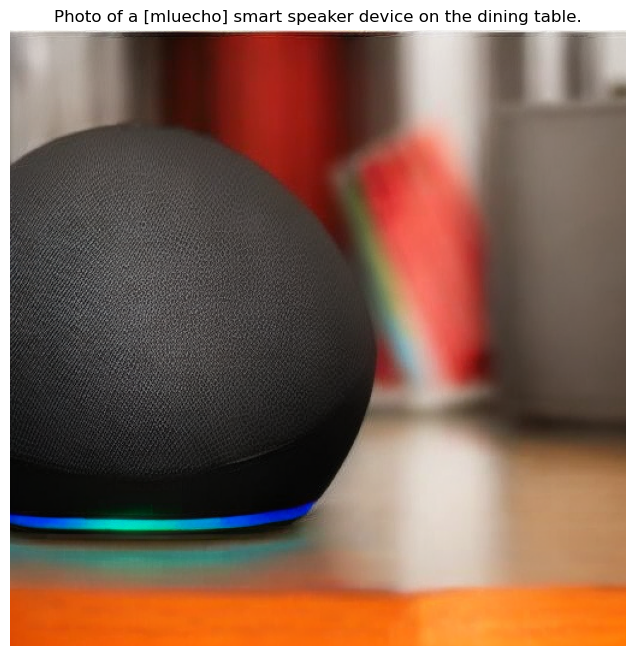

In [ ]:
payload["prompt"] = "Photo of a [mluecho] smart speaker device on the dining table."
response = query_response(finetuned_predictor, payload)

Let's try different scenes for the 5th generation echo device

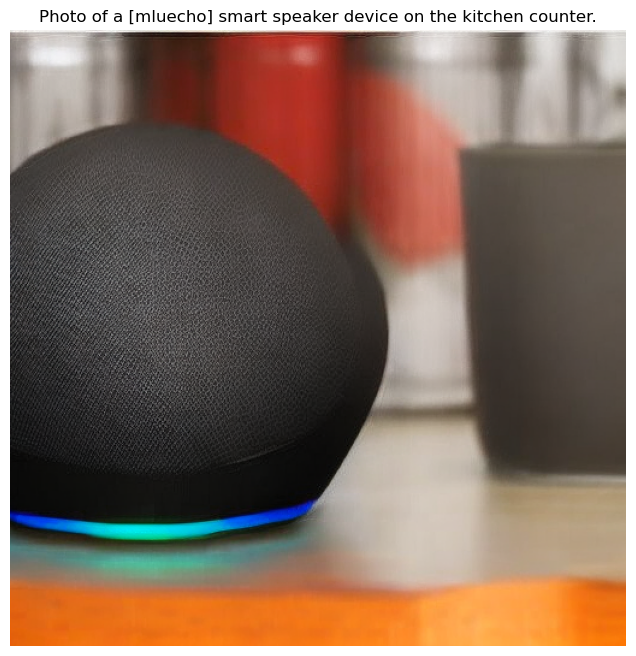

In [ ]:
payload["prompt"] = "Photo of a [mluecho] smart speaker device on the kitchen counter."
response = query_response(finetuned_predictor, payload)

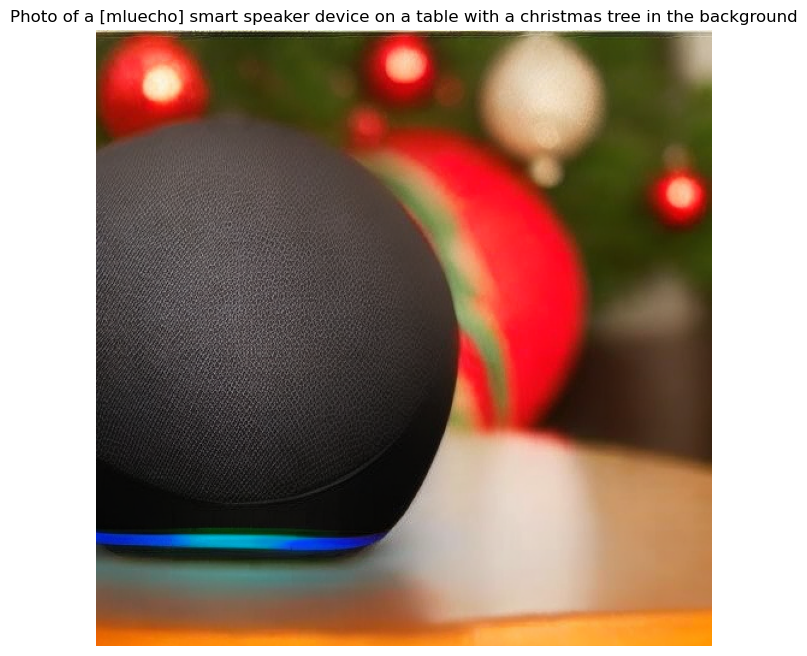

In [ ]:
payload["prompt"] = "Photo of a [mluecho] smart speaker device on a table with a christmas tree in the background"
response = query_response(finetuned_predictor, payload)

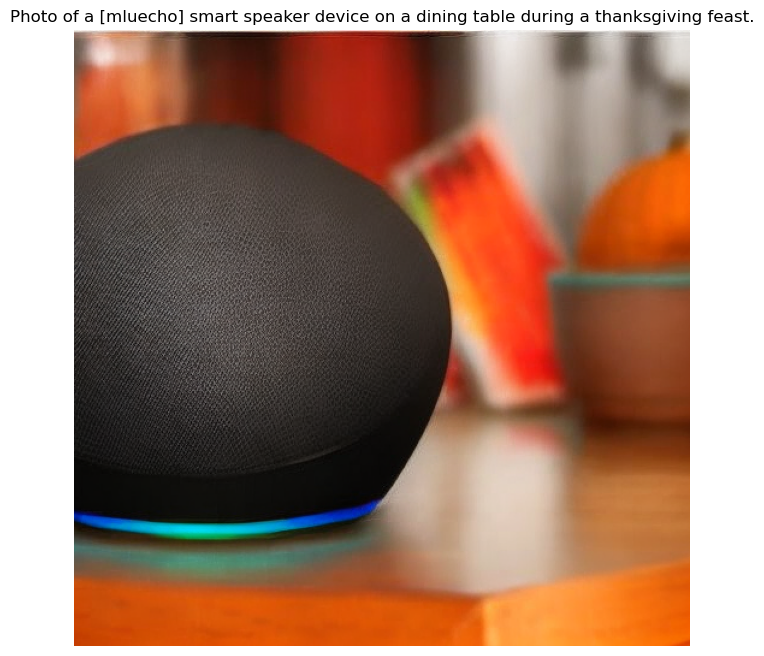

In [ ]:
payload["prompt"] = "Photo of a [mluecho] smart speaker device on a dining table during a thanksgiving feast."
response = query_response(finetuned_predictor, payload)

---
### <a name="#8">Clean up the endpoint</a>
(<a href="#0">Go to top</a>)

An endpoint deployed on SageMaker is persistent. We delete the endpoint with the following code.

In [ ]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2024-07-30-18-09-16-006
INFO:sagemaker:Deleting endpoint configuration with name: mlu-diffusion-models-FT-model-txt2img-s-2024-07-30-18-09-16-005
INFO:sagemaker:Deleting endpoint with name: mlu-diffusion-models-FT-model-txt2img-s-2024-07-30-18-09-16-005


---

### <a name="9">Quizzes</a>
(<a href="#0">Go to top</a>)

Well done on completing the lab! Now, it's time for a brief knowledge assessment.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;">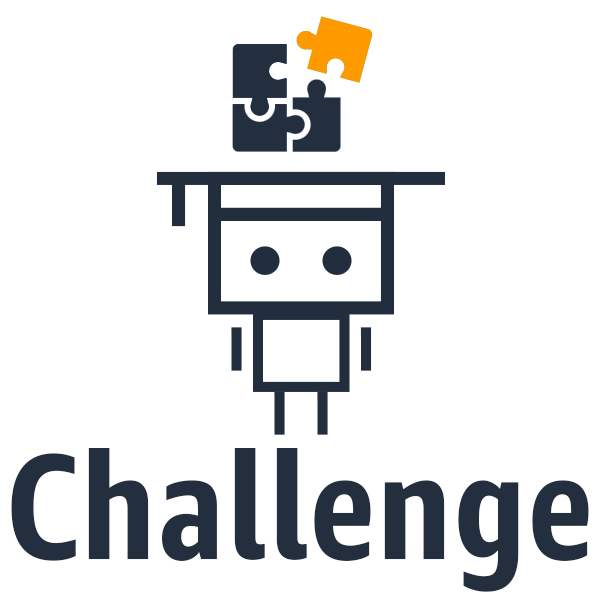 </p>
    <p style=" text-align: center; margin: auto;">Answer the following questions to test your understanding of using prompt templates for inference.</p>
    <br>
</div>

In [ ]:
from mlu_utils.quiz_questions import *

lab2_question1

In [ ]:
lab2_question2

<p style="padding: 10px; border: 1px solid black;">
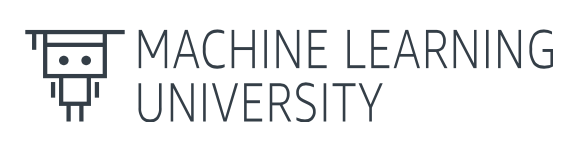 <br/>
# Thank you!